# United Airlines 2024 Hackathon Code Submission

## Belo Abhigyan
## Rajat Sharma

### Dept of Computer Science , University of Delhi


# **Data Review and Metric Calculation**

### Objective: Calculate Average Handle Time (AHT) and Average Speed to Answer (AST).

## Formula used:
### AHT = Total Handle Time / Total Number of Calls
### AST = Total Waiting Time / Total Number of Call

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to safely read CSV files because in calls.csv was encountering with parsing error at a specific row
def safe_read_csv(file_path):
    try:
        # First, try reading with default settings
        return pd.read_csv(file_path)
    except pd.errors.ParserError:
        # If that fails, try with the Python engine
        return pd.read_csv(file_path, engine='python')
    except Exception as e:
        print(f"Error reading {file_path}: {str(e)}")
        return pd.DataFrame()  # Return an empty DataFrame if all else fails

# Loading the given datasets
calls = safe_read_csv('calls.csv')
customers = safe_read_csv('customers.csv')
sentiment = safe_read_csv('sentiment_statistics.csv')
reason = safe_read_csv('reason.csv')

# Checking for any DataFrames are empty
if any(df.empty for df in [calls, customers, sentiment, reason]):
    print("One or more datasets could not be loaded. Please check the CSV files and error messages above.")
else:
    # Merging the datasets
    df = (
        calls.merge(customers, on='customer_id', how='left')
             .merge(sentiment, on='call_id', how='left')
             .merge(reason, on='call_id', how='left')
    )

    # Converting the datetime columns to datetime objects
    datetime_columns = ['call_start_datetime', 'agent_assigned_datetime', 'call_end_datetime']
    for col in datetime_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # Calculate Handle Time and Waiting Time
    df['handle_time'] = (df['call_end_datetime'] - df['agent_assigned_datetime']).dt.total_seconds()
    df['waiting_time'] = (df['agent_assigned_datetime'] - df['call_start_datetime']).dt.total_seconds()

    # You can add your analysis code here

# Example visualization (uncomment to use)
# plt.figure(figsize=(10, 6))
# sns.histplot(df['handle_time'], kde=True)
# plt.title('Distribution of Handle Time')
# plt.xlabel('Handle Time (seconds)')
# plt.ylabel('Frequency')
# plt.show()

In [2]:
    # Basic data info
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   call_id                  71810 non-null  int64         
 1   customer_id              71810 non-null  int64         
 2   agent_id_x               71810 non-null  int64         
 3   call_start_datetime      71810 non-null  datetime64[ns]
 4   agent_assigned_datetime  71810 non-null  datetime64[ns]
 5   call_end_datetime        71810 non-null  datetime64[ns]
 6   call_transcript          71810 non-null  object        
 7   customer_name            71810 non-null  object        
 8   elite_level_code         46043 non-null  float64       
 9   agent_id_y               71810 non-null  int64         
 10  agent_tone               71593 non-null  object        
 11  customer_tone            71810 non-null  object        
 12  average_sentiment        71701 n

In [3]:
print("\nSample of the merged dataset:")
print(df.head())


Sample of the merged dataset:
      call_id  customer_id  agent_id_x call_start_datetime  \
0  4667960400   2033123310      963118 2024-07-31 23:56:00   
1  1122072124   8186702651      519057 2024-08-01 00:03:00   
2  6834291559   2416856629      158319 2024-07-31 23:59:00   
3  2266439882   1154544516      488324 2024-08-01 00:05:00   
4  1211603231   5214456437      721730 2024-08-01 00:04:00   

  agent_assigned_datetime   call_end_datetime  \
0     2024-08-01 00:03:00 2024-08-01 00:34:00   
1     2024-08-01 00:06:00 2024-08-01 00:18:00   
2     2024-08-01 00:07:00 2024-08-01 00:26:00   
3     2024-08-01 00:10:00 2024-08-01 00:17:00   
4     2024-08-01 00:14:00 2024-08-01 00:23:00   

                                     call_transcript      customer_name  \
0  \n\nAgent: Thank you for calling United Airlin...     Matthew Foster   
1  \n\nAgent: Thank you for calling United Airlin...      Tammy Walters   
2  \n\nAgent: Thank you for calling United Airlin...      Jeffery Dixon   
3

In [4]:
# Handle missing values
df.dropna(subset=['handle_time', 'waiting_time'], inplace=True)
# Calculating the AHT and AST
total_handle_time = df['handle_time'].sum()
total_waiting_time = df['waiting_time'].sum()
total_calls = df.shape[0]
AHT = total_handle_time / total_calls
AST = total_waiting_time / total_calls

In [5]:
print(f"Average Handle Time (AHT): {AHT} seconds")
print(f"Average Speed to Answer (AST): {AST} seconds")

Average Handle Time (AHT): 697.0486004734717 seconds
Average Speed to Answer (AST): 437.0675393399248 seconds


# **Identifying Key Drivers of AHT and AST**

### Objective: Identify factors contributing to high AHT and AST, such as call types, agent efficiency, customer sentiment, and peak call times

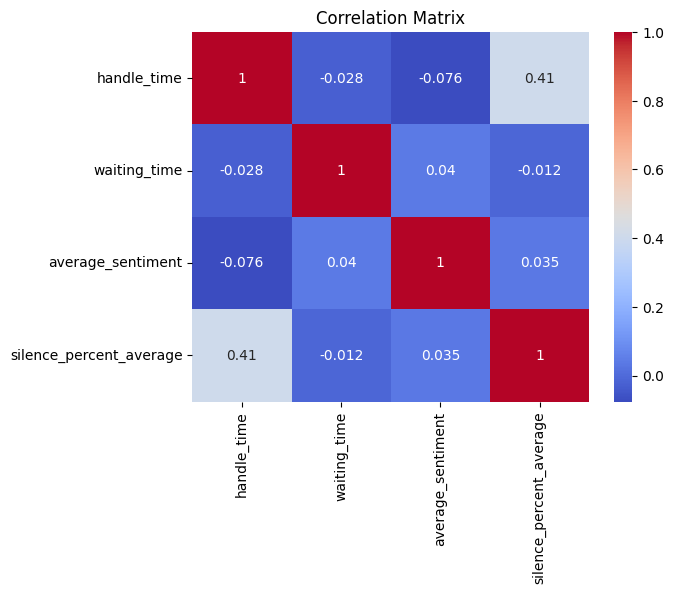

In [6]:
 # Finding the Correlation analysis with the help of heatmap
correlation = df[['handle_time', 'waiting_time', 'average_sentiment',
'silence_percent_average']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

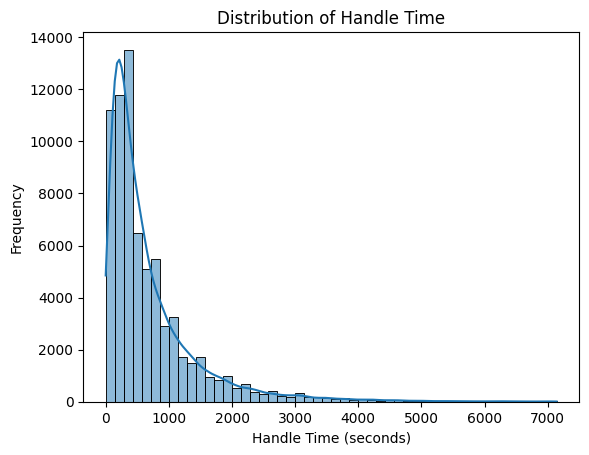

In [7]:
# Distribution of Handle Time
sns.histplot(df['handle_time'], bins=50, kde=True)
plt.title('Distribution of Handle Time')
plt.xlabel('Handle Time (seconds)')
plt.ylabel('Frequency')
plt.show()

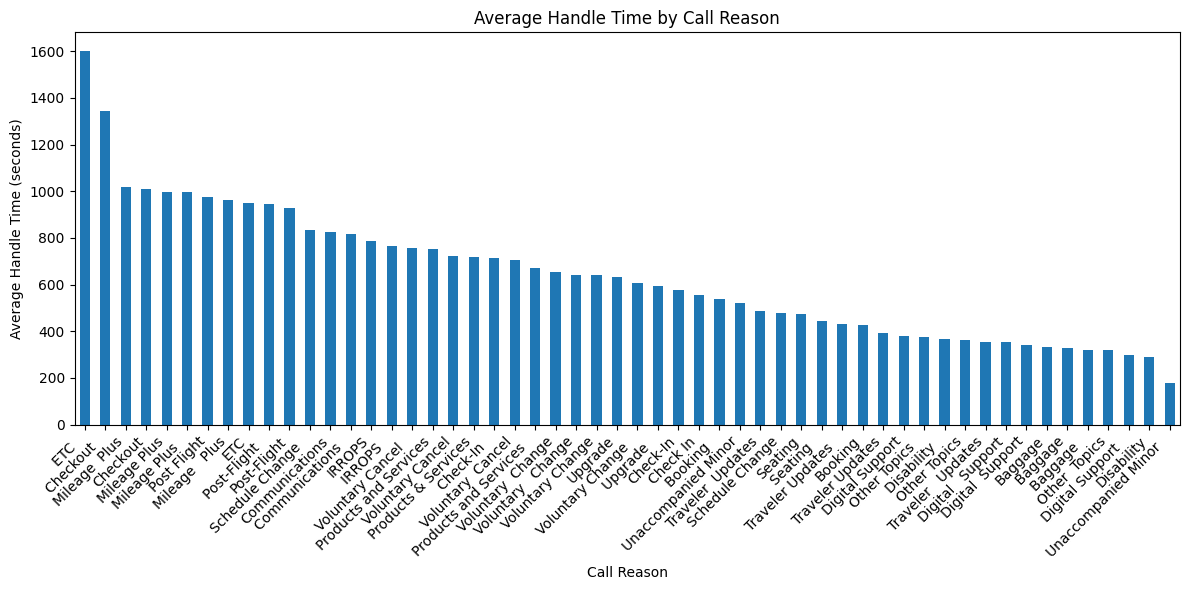

In [8]:
# Analyzing by call reason
if 'primary_call_reason' in df.columns:
    reason_aht = df.groupby('primary_call_reason')['handle_time'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    reason_aht.plot(kind='bar')
    plt.title('Average Handle Time by Call Reason')
    plt.xlabel('Call Reason')
    plt.ylabel('Average Handle Time (seconds)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # # Calculate percentage difference between most and least frequent call reasons
    # reason_counts = df['primary_call_reason'].value_counts()
    # most_frequent = reason_counts.index[0]
    # least_frequent = reason_counts.index[-1]

    # most_frequent_aht = df[df['primary_call_reason'] == most_frequent]['handle_time'].mean()
    # least_frequent_aht = df[df['primary_call_reason'] == least_frequent]['handle_time'].mean()

    # percent_diff = ((most_frequent_aht - least_frequent_aht) / least_frequent_aht) * 100

    # print(f"Percentage difference in AHT between most frequent ({most_frequent}) and least frequent ({least_frequent}) call reasons: {percent_diff:.2f}%")

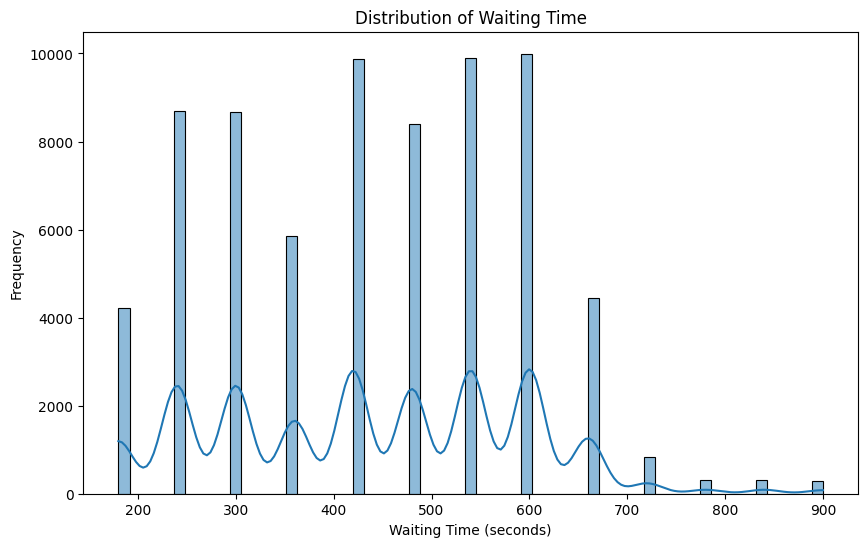

In [9]:
# Analyzing waiting time distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['waiting_time'], kde=True)
plt.title('Distribution of Waiting Time')
plt.xlabel('Waiting Time (seconds)')
plt.ylabel('Frequency')
plt.show()


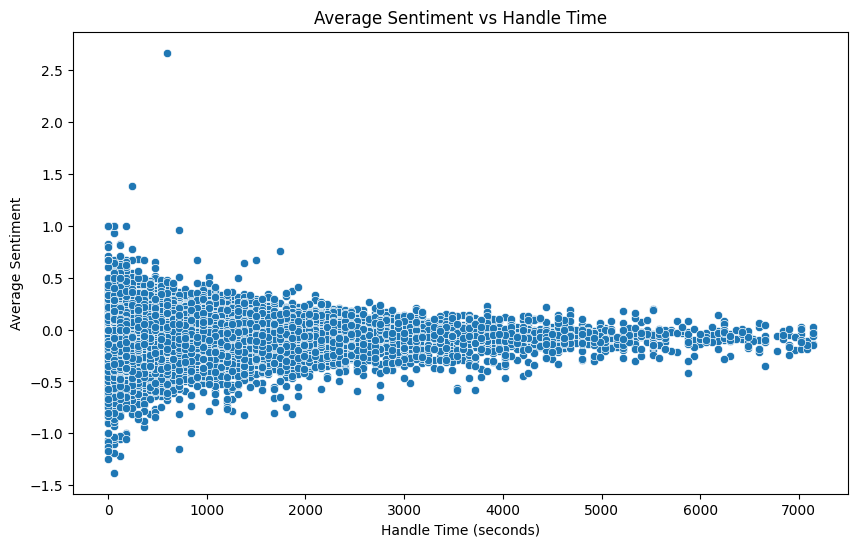

In [10]:

# Analyzing sentiment vs handle time
if 'average_sentiment' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='handle_time', y='average_sentiment', data=df)
    plt.title('Average Sentiment vs Handle Time')
    plt.xlabel('Handle Time (seconds)')
    plt.ylabel('Average Sentiment')
    plt.show()


In [11]:
# Display basic information about the DataFrame
print("Columns in the DataFrame:")
print(df.columns.tolist())

print("\nBasic information about the DataFrame:")
print(df.info())

print("\nSummary statistics:")
print(df.describe())

Columns in the DataFrame:
['call_id', 'customer_id', 'agent_id_x', 'call_start_datetime', 'agent_assigned_datetime', 'call_end_datetime', 'call_transcript', 'customer_name', 'elite_level_code', 'agent_id_y', 'agent_tone', 'customer_tone', 'average_sentiment', 'silence_percent_average', 'primary_call_reason', 'handle_time', 'waiting_time']

Basic information about the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71810 entries, 0 to 71809
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   call_id                  71810 non-null  int64         
 1   customer_id              71810 non-null  int64         
 2   agent_id_x               71810 non-null  int64         
 3   call_start_datetime      71810 non-null  datetime64[ns]
 4   agent_assigned_datetime  71810 non-null  datetime64[ns]
 5   call_end_datetime        71810 non-null  datetime64[ns]
 6   call_transcript  

          handle_time  average_sentiment  silence_percent_average
agent_id                                                         
102574         3600.0          -0.075000                 0.260000
506130         2880.0          -0.030000                 0.390000
255256         2620.0           0.036667                 0.443333
140146         2620.0          -0.066667                 0.420000
558705         1980.0           0.020000                 0.180000


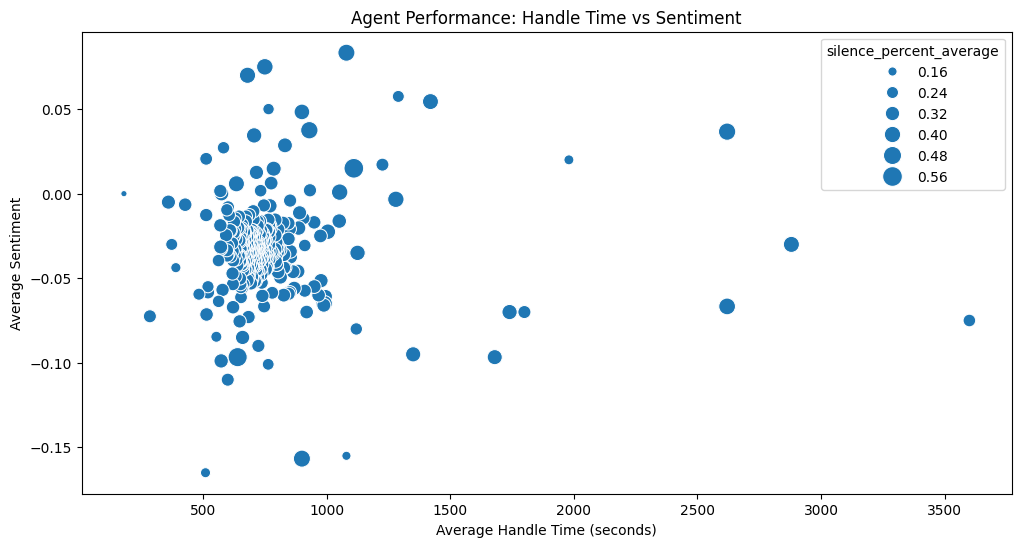

In [13]:
# Since we have two agent ID features so we are
# Creating a single agent ID by combining agent_id_x and agent_id_y
df['agent_id'] = df['agent_id_x'].combine_first(df['agent_id_y'])

# Now you can analyze performance based on the combined agent_id
if 'agent_id' in df.columns:
    agent_performance = df.groupby('agent_id').agg({
        'handle_time': 'mean',
        'average_sentiment': 'mean',
        'silence_percent_average': 'mean'
    }).sort_values('handle_time', ascending=False)

    # Check if the DataFrame is not empty
    print(agent_performance.head())  # Print first few rows to ensure data exists

    # Plot the data
    if not agent_performance.empty:
        plt.figure(figsize=(12, 6))
        sns.scatterplot(x='handle_time', y='average_sentiment', size='silence_percent_average',
                        data=agent_performance, sizes=(20, 200))
        plt.title('Agent Performance: Handle Time vs Sentiment')
        plt.xlabel('Average Handle Time (seconds)')
        plt.ylabel('Average Sentiment')
        plt.show()
    else:
        print("No data available for plotting.")
else:
    print("Column 'agent_id' does not exist in the DataFrame.")


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


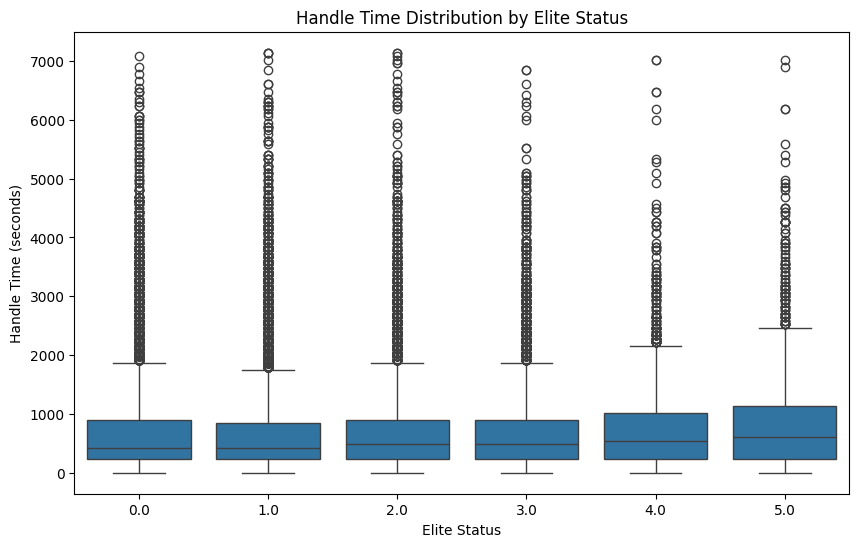

In [14]:

# Analyzint the impact of elite status on handle time
if 'elite_level_code' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='elite_level_code', y='handle_time', data=df)
    plt.title('Handle Time Distribution by Elite Status')
    plt.xlabel('Elite Status')
    plt.ylabel('Handle Time (seconds)')
    plt.show()

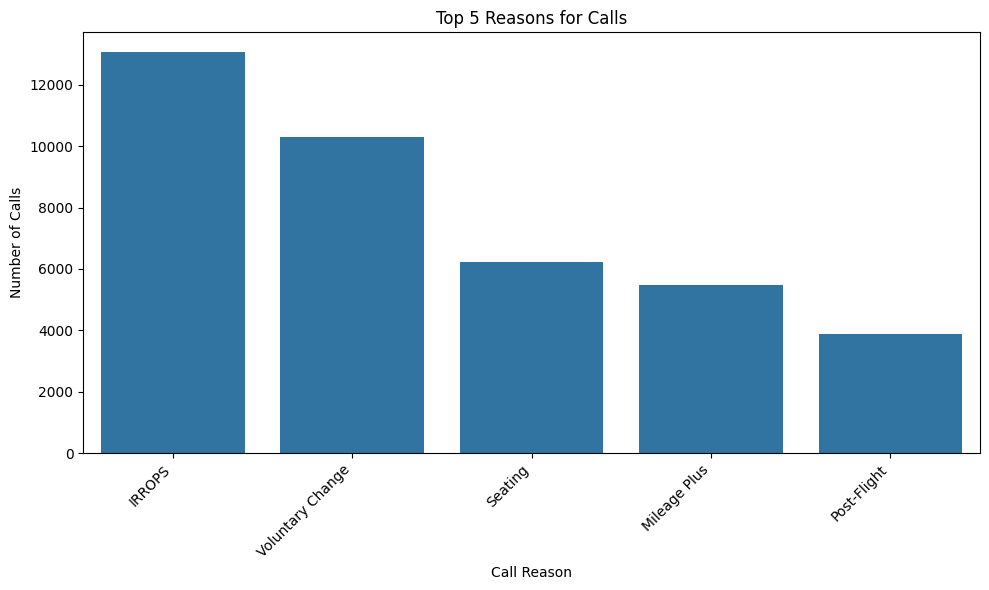

In [15]:

# Additional analysis: displaying the Top 5 reasons for calls
if 'primary_call_reason' in df.columns:
    top_5_reasons = df['primary_call_reason'].value_counts().nlargest(5)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_5_reasons.index, y=top_5_reasons.values)
    plt.title('Top 5 Reasons for Calls')
    plt.xlabel('Call Reason')
    plt.ylabel('Number of Calls')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# **Quantifying Handling Time Differences**

### Objective : Assess the percentage difference in AHT between the most frequent and least frequent call reasons to identify key drivers affecting handle time, especially during peak call volumes.

In [16]:
print(df['primary_call_reason'].isnull().sum())  # Count missing values to ease calculations

5157


In [17]:
# Step 1: Drop rows where primary_call_reason is missing
df_cleaned = df.dropna(subset=['primary_call_reason'])

# Step 2: Find the most and least frequent call reasons
call_reason_counts = df_cleaned['primary_call_reason'].value_counts()
most_frequent_reason = call_reason_counts.idxmax()  # Most frequent
least_frequent_reason = call_reason_counts.idxmin()  # Least frequent

# Step 3: Calculate average handling times for most and least frequent reasons
most_frequent_avg_handle_time = df_cleaned[df_cleaned['primary_call_reason'] == most_frequent_reason]['handle_time'].mean()
least_frequent_avg_handle_time = df_cleaned[df_cleaned['primary_call_reason'] == least_frequent_reason]['handle_time'].mean()

# Step 4: Calculate the percentage difference
percentage_difference = ((most_frequent_avg_handle_time - least_frequent_avg_handle_time) / least_frequent_avg_handle_time) * 100

# Output the results
print(f"Most frequent call reason: {most_frequent_reason}")
print(f"Least frequent call reason: {least_frequent_reason}")
print(f"Average handling time for most frequent: {most_frequent_avg_handle_time}")
print(f"Average handling time for least frequent: {least_frequent_avg_handle_time}")
print(f"Percentage difference: {percentage_difference}%")


Most frequent call reason: IRROPS
Least frequent call reason: Unaccompanied Minor  
Average handling time for most frequent: 785.4913073447193
Average handling time for least frequent: 180.0
Percentage difference: 336.38405963595517%


#  Improving IVR System to Reduce Agent Escalations

###  Objective
 ##### Enhance the Interactive Voice Response (IVR) system to handle common call reasons through self-service,thereby reducing the likelihood of agent escalations and improving overall call center efficiency.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
nltk.download('stopwords')

# Load datasets
calls = pd.read_csv('calls.csv')
customers = pd.read_csv('customers.csv')
sentiment = pd.read_csv('sentiment_statistics.csv')
reason = pd.read_csv('reason.csv')

# Merging the datasets
df = (
    calls.merge(customers, on='customer_id', how='left')
         .merge(sentiment, on='call_id', how='left')
         .merge(reason, on='call_id', how='left')
)

# Calculating handle time
df['handle_time'] = (pd.to_datetime(df['call_end_datetime']) - pd.to_datetime(df['agent_assigned_datetime'])).dt.total_seconds()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    stop_words = set(stopwords.words('english'))
    words = text.split()
    return ' '.join([word for word in words if word not in stop_words])

# Apply preprocessing to call transcripts
df['processed_transcript'] = df['call_transcript'].apply(preprocess_text)

# Use TF-IDF to extract features from transcripts
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['processed_transcript'])

# Cluster transcripts to identify common themes
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Analyze clusters to identify common themes and potential self-solvable issues
cluster_themes = {}
potential_self_service_options = {}

for cluster in range(n_clusters):
    cluster_transcripts = df[df['cluster'] == cluster]['processed_transcript']
    cluster_words = ' '.join(cluster_transcripts).split()
    word_freq = Counter(cluster_words)
    top_words = word_freq.most_common(10)
    cluster_themes[cluster] = [word for word, _ in top_words]

    print(f"Cluster {cluster} top words:")
    print(', '.join([word for word, _ in top_words]))

    # Analyze call reasons within the cluster
    cluster_reasons = df[df['cluster'] == cluster]['primary_call_reason'].value_counts()
    print("Top call reasons for this cluster:")
    print(cluster_reasons.head())

    # Identify potential self-service options based on top words and call reasons
    potential_options = []
    for word, _ in top_words:
        if any(word in reason.lower() for reason in cluster_reasons.index):
            potential_options.append(word)

    potential_self_service_options[cluster] = potential_options

    print("Potential self-service options for this cluster:")
    print(', '.join(potential_options))
    print("\n")

# Analyze handle time for potential self-service options
for cluster, options in potential_self_service_options.items():
    for option in options:
        option_calls = df[(df['cluster'] == cluster) & (df['primary_call_reason'].str.contains(option, case=False, na=False))]
        if not option_calls.empty:
            avg_handle_time = option_calls['handle_time'].mean()
            print(f"Cluster {cluster}, Option '{option}' average handle time: {avg_handle_time:.2f} seconds")

# Estimate potential time savings
total_calls = len(df)
potential_self_service_calls = sum(len(df[(df['cluster'] == cluster) & (df['primary_call_reason'].str.contains('|'.join(options), case=False, na=False))])
                                   for cluster, options in potential_self_service_options.items())
potential_time_saved = sum(df[(df['cluster'] == cluster) & (df['primary_call_reason'].str.contains('|'.join(options), case=False, na=False))]['handle_time'].sum()
                           for cluster, options in potential_self_service_options.items())

print(f"\nPotential self-service calls: {potential_self_service_calls} ({potential_self_service_calls/total_calls*100:.2f}% of total calls)")
print(f"Potential time saved: {potential_time_saved/3600:.2f} hours")


print("\nProposed IVR Improvements:")
for cluster, options in potential_self_service_options.items():
    for option in options:
        print(f"1. Add a self-service option for '{option}' related inquiries")
print("2. Implement a natural language processing system to better understand customer intents")
print("3. Create a feedback loop to continuously improve IVR options based on customer interactions")
print("4. Integrate the IVR system with relevant databases for up-to-date information")
print("5. Offer callback options for complex issues that cannot be resolved through self-service")



Cluster 0 top words:
flight, agent, customer, change, let, friday, help, would, need, im
Top call reasons for this cluster:
primary_call_reason
IRROPS              1205
Voluntary Change     839
Seating              517
Mileage Plus         361
Communications       299
Name: count, dtype: int64
Potential self-service options for this cluster:
flight, change


Cluster 1 top words:
customer, agent, flight, im, let, united, delay, thank, like, help
Top call reasons for this cluster:
primary_call_reason
IRROPS              1312
Voluntary Change     827
Seating              541
Mileage Plus         432
Communications       339
Name: count, dtype: int64
Potential self-service options for this cluster:
flight


Cluster 2 top words:
agent, customer, flight, change, let, fee, would, help, im, thank
Top call reasons for this cluster:
primary_call_reason
IRROPS              1970
Voluntary Change    1375
Seating              836
Mileage Plus         763
Communications       572
Name: count, dtype: 

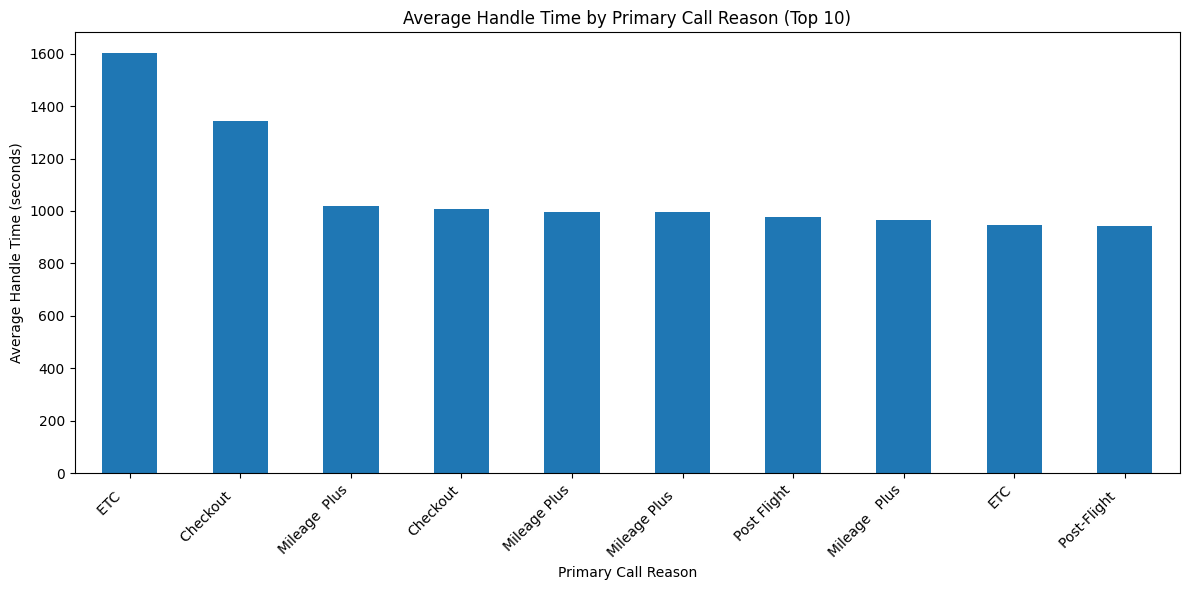

In [21]:
# Analyze relationship between call reasons and handle time
reason_handle_time = df.groupby('primary_call_reason')['handle_time'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
reason_handle_time.head(10).plot(kind='bar')
plt.title('Average Handle Time by Primary Call Reason (Top 10)')
plt.xlabel('Primary Call Reason')
plt.ylabel('Average Handle Time (seconds)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

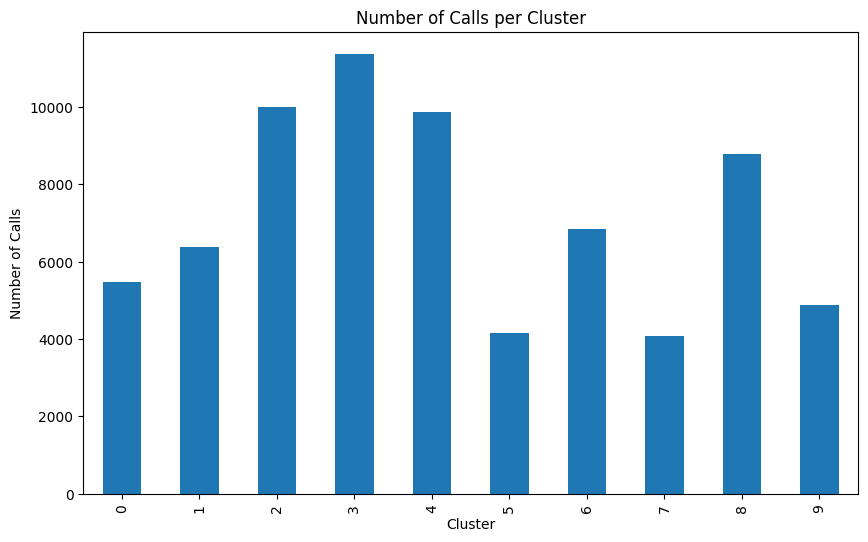

In [22]:
# Visualize cluster sizes
plt.figure(figsize=(10, 6))
df['cluster'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Calls per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Calls')
plt.show()


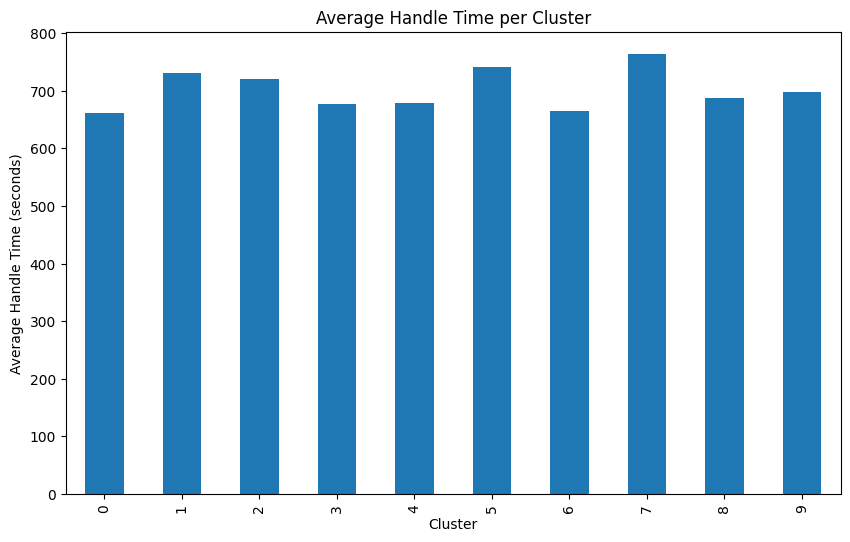

In [23]:
# Visualize average handle time per cluster
plt.figure(figsize=(10, 6))
df.groupby('cluster')['handle_time'].mean().plot(kind='bar')
plt.title('Average Handle Time per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Handle Time (seconds)')
plt.show()

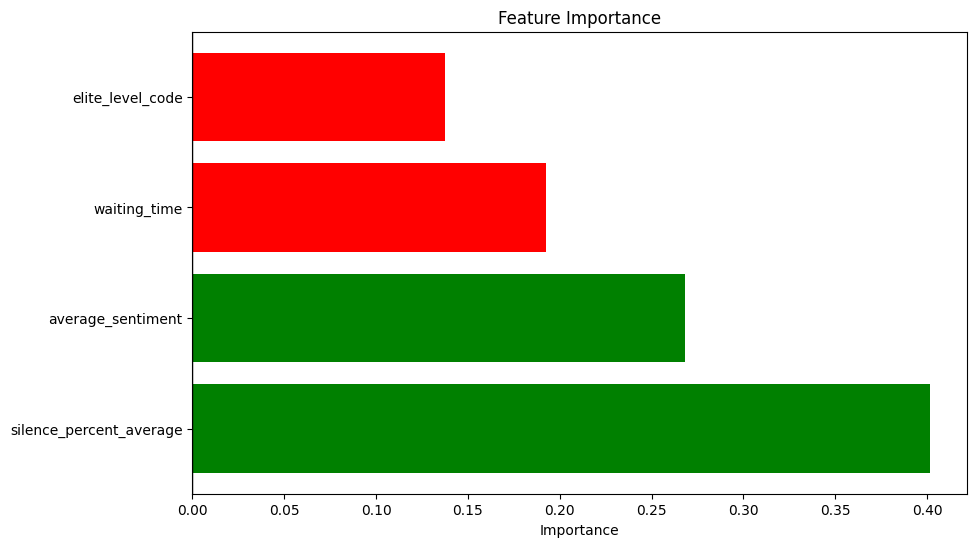

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

# Feature selection: select relevant numerical and categorical columns
features = ['waiting_time', 'average_sentiment', 'silence_percent_average', 'elite_level_code']
target = 'handle_time'

# Encode categorical features like 'elite_level_code'
df_cleaned['elite_level_code'] = LabelEncoder().fit_transform(df_cleaned['elite_level_code'].astype(str))

# Drop rows with missing values in the features or target
df_cleaned.dropna(subset=features + [target], inplace=True)

# Prepare X (features) and y (target)
X = df_cleaned[features]
y = df_cleaned[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for feature importance for easier plotting
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Prepare data for plotting
top_4_features = feature_importance_df.head(4)
bottom_2_features = feature_importance_df.tail(2)

# Ensure we have distinct features for plotting
combined_features = pd.concat([top_4_features, bottom_2_features])

# Make unimportant features negative for clarity in plotting
combined_features['Importance'] = combined_features['Importance'] * (combined_features['Importance'].apply(lambda x: 1 if x > 0 else -1))

# Plot all features on a single bar plot
plt.figure(figsize=(10, 6))
colors = ['red' if x in bottom_2_features['Feature'].values else 'green' for x in combined_features['Feature']]
plt.barh(combined_features['Feature'], combined_features['Importance'], color=colors)
plt.axvline(0, color='black', lw=1)  # Add a vertical line at x=0 for clarity
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()


# Predictive Modelling (Optional)

In [35]:
import pandas as pd
import pickle
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

nltk.download('stopwords')

# Loading the datasets
calls = pd.read_csv('calls.csv')
customers = pd.read_csv('customers.csv')
sentiment = pd.read_csv('sentiment_statistics.csv')
reason = pd.read_csv('reason.csv')

# Merging datasets for training the model
df = (
    calls.merge(customers, on='customer_id', how='left')
         .merge(sentiment, on='call_id', how='left')
         .merge(reason, on='call_id', how='left')
)


# Defining  the preprocessing function
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    stop_words = set(stopwords.words('english'))
    words = text.split()
    return ' '.join([word for word in words if word not in stop_words])

# Preprocesing  the call transcripts
df['processed_transcript'] = df['call_transcript'].apply(preprocess_text)

# Checking for any NaNs in training data
print("Number of NaNs in each feature (training data):")
print(df[['processed_transcript', 'primary_call_reason']].isnull().sum())

# # Checking for NaNs in test data
# print("\nNumber of NaNs in 'processed_transcript' (test data):")
# print(test_df['processed_transcript'].isnull().sum())

# Dropping rows with NaNs in 'processed_transcript' or 'primary_call_reason'
df = df.dropna(subset=['processed_transcript', 'primary_call_reason'])

# Performing Feature Extraction
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['processed_transcript'])
y = df['primary_call_reason']

# Train-Test Spliting of Data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#  Training the model with help of Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model (optional)
# from sklearn.metrics import classification_report
# y_pred = model.predict(X_val)
# print(classification_report(y_val, y_pred))

# Save the model and vectorizer
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# **Prediction Steps**

# Load the testing data
test_df = pd.read_csv('test.csv')  # Contains only 'call_id'

# Merge with 'calls.csv' to get 'call_transcript'
test_df = test_df.merge(calls[['call_id', 'call_transcript']], on='call_id', how='left')

# Check for missing transcripts and handle them
missing_transcripts = test_df['call_transcript'].isnull().sum()
print(f"Missing call transcripts: {missing_transcripts}")
test_df.dropna(subset=['call_transcript'], inplace=True)

# Preprocess the call transcripts
test_df['processed_transcript'] = test_df['call_transcript'].apply(preprocess_text)

# Load the model and vectorizer
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)
with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

# Transform the test data
X_new = vectorizer.transform(test_df['processed_transcript'])

# Make future predictions
predictions = model.predict(X_new)
test_df['primary_call_reason'] = predictions

# Save the predictions in a new file
test_df[['call_id', 'primary_call_reason']].to_csv('test_<name>.csv', index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of NaNs in each feature (training data):
processed_transcript       0
primary_call_reason     5157
dtype: int64
Missing call transcripts: 0


In [37]:

# Evaluate the model (optional)
from sklearn.metrics import classification_report
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

                Baggage       0.00      0.00      0.00        21
                Baggage       0.17      0.00      0.00       554
              Baggage         0.00      0.00      0.00        29
                Booking       0.11      0.00      0.00       497
              Booking         0.00      0.00      0.00        16
               Check In       0.00      0.00      0.00        76
               Check-In       0.00      0.00      0.00       276
             Check-In         0.00      0.00      0.00         7
               Checkout       0.00      0.00      0.00       373
             Checkout         0.00      0.00      0.00        11
         Communications       0.00      0.00      0.00       746
       Communications         0.00      0.00      0.00        11
      Digital   Support       0.00      0.00      0.00        32
       Digital  Support       0.00      0.00      0.00        19
        Digital Support 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
